# Residual Attention Network for Image Classification

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

train_images = train_images/255.0
test_images = test_images/255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
 
print(f"Train samples: {train_images.shape}, {train_labels.shape}")
print(f"Test samples: {test_images.shape}, {test_labels.shape}")

Train samples: (50000, 32, 32, 3), (50000, 1)
Test samples: (10000, 32, 32, 3), (10000, 1)


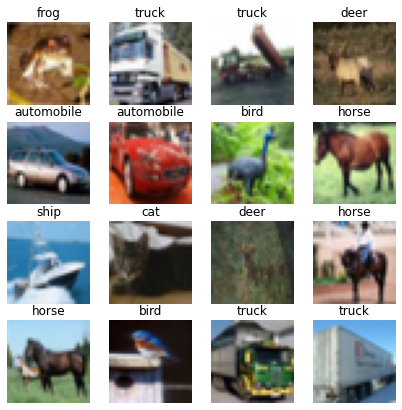

In [3]:
plt.figure(figsize=(7, 7))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(train_images[i])
    plt.title(class_names[train_labels[i][0]])
    plt.axis('off')
plt.show()

## Residual unit

In [137]:
class Residual_Unit(tf.keras.Model):
    def __init__(self, in_channels, out_channels=None, strides=1, **kwargs):
        super(Residual_Unit, self).__init__(**kwargs)
        self.in_channels = in_channels
        self.strides = strides
        
        self.conv1 = tf.keras.layers.Conv2D(filters=self.in_channels//4, kernel_size=1, strides=1, padding='same', use_bias=False)
        self.BN1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.ReLU()
        
        self.conv2 = tf.keras.layers.Conv2D(filters=self.in_channels//4, kernel_size=3, strides=self.strides, padding='same', use_bias=False)
        self.BN2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.ReLU()
        
        self.conv3 = tf.keras.layers.Conv2D(filters=self.in_channels, kernel_size=1, strides=1, padding='same', use_bias=False)
        self.BN3 = tf.keras.layers.BatchNormalization()
        self.relu3 = tf.keras.layers.ReLU()
        
        
    def call(self, x):
        shortcut = x
        outputs = self.conv1(x)
        outputs = self.BN1(outputs)
        outputs = self.relu1(outputs)
        
        outputs = self.conv2(outputs)
        outputs = self.BN2(outputs)
        outputs = self.relu2(outputs)
        
        outputs = self.conv3(outputs)
        outputs = self.BN3(outputs)
        outputs = tf.add(outputs, shortcut)
        outputs = self.relu3(outputs)
        return outputs

In [143]:
inputs = tf.keras.Input((56, 56, 64))

In [144]:
R = Residual_Unit(256, 2)

In [145]:
R(inputs)

ValueError: in user code:

    <ipython-input-137-962d7efdd1d5>:32 call  *
        outputs = tf.add(outputs, shortcut)
    C:\Users\kwon\anaconda3\lib\site-packages\tensorflow\python\ops\gen_math_ops.py:356 add  **
        "Add", x=x, y=y, name=name)
    C:\Users\kwon\anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    C:\Users\kwon\anaconda3\lib\site-packages\tensorflow\python\framework\func_graph.py:593 _create_op_internal
        compute_device)
    C:\Users\kwon\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:3485 _create_op_internal
        op_def=op_def)
    C:\Users\kwon\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:1975 __init__
        control_input_ops, op_def)
    C:\Users\kwon\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 28 and 56 for '{{node residual__unit_27/Add}} = Add[T=DT_FLOAT](residual__unit_27/batch_normalization_82/cond/Identity, input_20)' with input shapes: [?,28,28,256], [?,56,56,64].


In [136]:
R.summary()

Model: "residual__unit_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_75 (Conv2D)           (None, 32, 32, 8)         256       
_________________________________________________________________
batch_normalization_74 (Batc (None, 32, 32, 8)         32        
_________________________________________________________________
re_lu_66 (ReLU)              (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 32, 32, 8)         576       
_________________________________________________________________
batch_normalization_75 (Batc (None, 32, 32, 8)         32        
_________________________________________________________________
re_lu_67 (ReLU)              (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 32, 32, 32)  

## attention module

### Trunk Brunch

In [108]:
class Trunk_Brunch(tf.keras.layers.Layer):
    def __init__(self, channels, t=2, **kwargs):
        super(Trunk_Brunch, self).__init__(**kwargs)
        self.channels = channels
        self.t = t
        self.residual_units = []
        for _ in range(self.t):  
            self.residual_units.append(Residual_Unit(self.channels))
            
    def call(self, x):
        for i in range(self.t):
            x = self.residual_units[i](x)
        return x

In [113]:
T = Trunk_Brunch(32)

In [114]:
inputs = tf.keras.Input((32, 32, 32))

In [115]:
T(inputs)

<tf.Tensor 'trunk__brunch_14/residual__unit_21/re_lu_56/Relu:0' shape=(None, 32, 32, 32) dtype=float32>

### Mask Brunch 

In [16]:
class Mask_Brunch(tf.keras.layers.Layer):
    def __init__(self, num_of_filters, r=1, num_of_pool=2, **kwargs):
        super(Mask_Brunch, self).__init__(**kwargs)
        self.r = r
        self.stage = stage
        self.filters = num_of_filters
        
        for i in range(num_of_pool):
            self.maxpooling = tf.keras.layers.MaxPool2D((2, 2))
            for _ in range(r):
                self.residual_unit = ResidualBlock(self.channels)
            self.skip_connection = ResidualBlock(self.channels)
            
        self.upsampling = tf.keras.layers.UpSampling2D(size=(2, 2))
        self.BN1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.ReLU()
        
        self.conv1 = tf.keras.layers.Conv2D(filters=self.filters, kernel_size=1, strides=1)
        self.BN2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.ReLU()
        
        self.conv2 = tf.keras.layers.Conv2D(filters=self.filters, kernel_size=1, strides=1)
        self.sigmoid = tf.keras.layers.sigmoid()
        
    def call(self, inputs):
        pass

### attention module

In [ ]:
class Attention_Module(tf.keras.layers.Layer):
    def __init__(self, channels, stage=0, **kwargs):
        super(Attention_Module, self).__init__(**kwargs)
        self.channels = channels
        self.stage = stage
        
        self.residual_block = ResidualBlock(self.channels)
        
        #Trunk Brunch
        self.trunk_residual_block1 = ResidualBlock(self.channels)
        self.trunk_residual_block2 = ResidualBlock(self.channels)
        
        

In [ ]:
class AttentionModule_stage0(nn.HybridBlock):
    def __init__(self, channels, size1=112, size2=56, size3=28, size4=14, **kwargs):
        super(AttentionModule_stage0, self).__init__(**kwargs)
        with self.name_scope():
            self.first_residual_blocks = ResidualBlock(channels)

            self.trunk_branches = nn.HybridSequential()
            with self.trunk_branches.name_scope():
                self.trunk_branches.add(ResidualBlock(channels))
                self.trunk_branches.add(ResidualBlock(channels))

            self.mpool1 = nn.MaxPool2D(pool_size=3, strides=2, padding=1)
            self.softmax1_blocks = ResidualBlock(channels)
            self.skip1_connection_residual_block = ResidualBlock(channels)

            self.mpool2 = nn.MaxPool2D(pool_size=3, strides=2, padding=1)
            self.softmax2_blocks = ResidualBlock(channels)
            self.skip2_connection_residual_block = ResidualBlock(channels)

            self.mpool3 = nn.MaxPool2D(pool_size=3, strides=2, padding=1)
            self.softmax3_blocks = ResidualBlock(channels)
            self.skip3_connection_residual_block = ResidualBlock(channels)

            self.mpool4 = nn.MaxPool2D(pool_size=3, strides=2, padding=1)
            self.softmax4_blocks = nn.HybridSequential()
            with self.softmax4_blocks.name_scope():
                self.softmax4_blocks.add(ResidualBlock(channels))
                self.softmax4_blocks.add(ResidualBlock(channels))

            self.interpolation4 = UpsamplingBilinear2d(size=size4)
            self.softmax5_blocks = ResidualBlock(channels)

            self.interpolation3 = UpsamplingBilinear2d(size=size3)
            self.softmax6_blocks = ResidualBlock(channels)

            self.interpolation2 = UpsamplingBilinear2d(size=size2)
            self.softmax7_blocks = ResidualBlock(channels)

            self.interpolation1 = UpsamplingBilinear2d(size=size1)

            self.softmax8_blocks = nn.HybridSequential()
            with self.softmax8_blocks.name_scope():
                self.softmax8_blocks.add(nn.BatchNorm())
                self.softmax8_blocks.add(nn.Activation('relu'))
                self.softmax8_blocks.add(nn.Conv2D(channels, kernel_size=1, strides=1, use_bias=False))
                self.softmax8_blocks.add(nn.BatchNorm())
                self.softmax8_blocks.add(nn.Activation('relu'))
                self.softmax8_blocks.add(nn.Conv2D(channels, kernel_size=1, strides=1, use_bias=False))
                self.softmax8_blocks.add(nn.Activation('sigmoid'))

            self.last_blocks = ResidualBlock(channels)

    def hybrid_forward(self, F, x, *args, **kwargs):
        x = self.first_residual_blocks(x)
        out_trunk = self.trunk_branches(x)

        out_mpool1 = self.mpool1(x)
        out_softmax1 = self.softmax1_blocks(out_mpool1)
        out_skip1_connection = self.skip1_connection_residual_block(out_softmax1)
        # 56 x 56

        out_mpool2 = self.mpool2(out_softmax1)
        out_softmax2 = self.softmax2_blocks(out_mpool2)
        out_skip2_connection = self.skip2_connection_residual_block(out_softmax2)
        # 28 x 28

        out_mpool3 = self.mpool3(out_softmax2)
        out_softmax3 = self.softmax3_blocks(out_mpool3)
        out_skip3_connection = self.skip3_connection_residual_block(out_softmax3)
        # 14 x 14

        out_mpool4 = self.mpool4(out_softmax3)
        out_softmax4 = self.softmax4_blocks(out_mpool4)
        # 7 x 7

        out_interp4 = F.elemwise_add(self.interpolation4(out_softmax4), out_softmax3)
        out = F.elemwise_add(out_interp4, out_skip3_connection)

        out_softmax5 = self.softmax5_blocks(out)
        out_interp3 = F.elemwise_add(self.interpolation3(out_softmax5), out_softmax2)
        out = F.elemwise_add(out_interp3, out_skip2_connection)

        out_softmax6 = self.softmax5_blocks(out)
        out_interp2 = F.elemwise_add(self.interpolation2(out_softmax6), out_softmax1)
        out = F.elemwise_add(out_interp2, out_skip1_connection)

        out_softmax7 = self.softmax7_blocks(out)
        out_interp1 = F.elemwise_add(self.interpolation1(out_softmax7), out_trunk)

        out_softmax8 = self.softmax8_blocks(out_interp1)
        out = F.elemwise_add(F.ones_like(out_softmax8), out_softmax8)
        out = F.elemwise_mul(out, out_trunk)

        out_last = self.last_blocks(out)

        return out_last


class AttentionModule_stage1(nn.HybridBlock):
    def __init__(self, channels, size1=56, size2=28, size3=14, **kwargs):
        """
        Input size is 56 x 56
        :param channels:
        :param type:
        :param size1:
        :param size2:
        :param size3:
        """
        super(AttentionModule_stage1, self).__init__(**kwargs)
        with self.name_scope():
            self.first_residual_blocks = ResidualBlock(channels)

            self.trunk_branches = nn.HybridSequential()
            with self.trunk_branches.name_scope():
                self.trunk_branches.add(ResidualBlock(channels))
                self.trunk_branches.add(ResidualBlock(channels))

            self.mpool1 = nn.MaxPool2D(pool_size=3, strides=2, padding=1)
            self.softmax1_blocks = ResidualBlock(channels)
            self.skip1_connection_residual_block = ResidualBlock(channels)

            self.mpool2 = nn.MaxPool2D(pool_size=3, strides=2, padding=1)
            self.softmax2_blocks = ResidualBlock(channels)
            self.skip2_connection_residual_block = ResidualBlock(channels)

            self.mpool3 = nn.MaxPool2D(pool_size=3, strides=2, padding=1)

            self.softmax3_blocks = nn.HybridSequential()
            with self.softmax3_blocks.name_scope():
                self.softmax3_blocks.add(ResidualBlock(channels))
                self.softmax3_blocks.add(ResidualBlock(channels))

            self.interpolation3 = UpsamplingBilinear2d(size=size3)
            self.softmax4_blocks = ResidualBlock(channels)

            self.interpolation2 = UpsamplingBilinear2d(size=size2)
            self.softmax5_blocks = ResidualBlock(channels)

            self.interpolation1 = UpsamplingBilinear2d(size=size1)

            self.softmax6_blocks = nn.HybridSequential()
            with self.softmax6_blocks.name_scope():
                self.softmax6_blocks.add(nn.BatchNorm())
                self.softmax6_blocks.add(nn.Activation('relu'))
                self.softmax6_blocks.add(nn.Conv2D(channels, kernel_size=1, strides=1, use_bias=False))
                self.softmax6_blocks.add(nn.BatchNorm())
                self.softmax6_blocks.add(nn.Activation('relu'))
                self.softmax6_blocks.add(nn.Conv2D(channels, kernel_size=1, strides=1, use_bias=False))
                self.softmax6_blocks.add(nn.Activation('sigmoid'))

            self.last_blocks = ResidualBlock(channels)

    def hybrid_forward(self, F, x, *args, **kwargs):
        x = self.first_residual_blocks(x)
        out_trunk = self.trunk_branches(x)

        out_mpool1 = self.mpool1(x)
        out_softmax1 = self.softmax1_blocks(out_mpool1)
        out_skip1_connection = self.skip1_connection_residual_block(out_softmax1)

        out_mpool2 = self.mpool2(out_softmax1)
        out_softmax2 = self.softmax2_blocks(out_mpool2)
        out_skip2_connection = self.skip2_connection_residual_block(out_softmax2)

        out_mpool3 = self.mpool3(out_softmax2)
        out_softmax3 = self.softmax3_blocks(out_mpool3)

        out_interp3 = F.elemwise_add(self.interpolation3(out_softmax3), out_softmax2)
        out = F.elemwise_add(out_interp3, out_skip2_connection)

        out_softmax4 = self.softmax4_blocks(out)
        out_interp2 = F.elemwise_add(self.interpolation2(out_softmax4), out_softmax1)
        out = F.elemwise_add(out_interp2, out_skip1_connection)

        out_softmax5 = self.softmax5_blocks(out)
        out_interp1 = F.elemwise_add(self.interpolation1(out_softmax5), out_trunk)

        out_softmax6 = self.softmax6_blocks(out_interp1)
        out = F.elemwise_add(F.ones_like(out_softmax6), out_softmax6)
        out = F.elemwise_mul(out, out_trunk)

        out_last = self.last_blocks(out)

        return out_last


class AttentionModule_stage2(nn.HybridBlock):
    def __init__(self, channels, size1=28, size2=14, **kwargs):
        """
        Input size is 28 x 28
        :param channels:
        :param type:
        :param size1:
        :param size2:
        """
        super(AttentionModule_stage2, self).__init__(**kwargs)
        with self.name_scope():
            self.first_residual_blocks = ResidualBlock(channels)

            self.trunk_branches = nn.HybridSequential()
            with self.trunk_branches.name_scope():
                self.trunk_branches.add(ResidualBlock(channels))
                self.trunk_branches.add(ResidualBlock(channels))

            self.mpool1 = nn.MaxPool2D(pool_size=3, strides=2, padding=1)
            self.softmax1_blocks = ResidualBlock(channels)
            self.skip1_connection_residual_block = ResidualBlock(channels)

            self.mpool2 = nn.MaxPool2D(pool_size=3, strides=2, padding=1)

            self.softmax2_blocks = nn.HybridSequential()
            with self.softmax2_blocks.name_scope():
                self.softmax2_blocks.add(ResidualBlock(channels))
                self.softmax2_blocks.add(ResidualBlock(channels))

            self.interpolation2 = UpsamplingBilinear2d(size=size2)
            self.softmax3_blocks = ResidualBlock(channels)

            self.interpolation1 = UpsamplingBilinear2d(size=size1)

            self.softmax4_blocks = nn.HybridSequential()
            with self.softmax4_blocks.name_scope():
                self.softmax4_blocks.add(nn.BatchNorm())
                self.softmax4_blocks.add(nn.Activation('relu'))
                self.softmax4_blocks.add(nn.Conv2D(channels, kernel_size=1, strides=1, use_bias=False))
                self.softmax4_blocks.add(nn.BatchNorm())
                self.softmax4_blocks.add(nn.Activation('relu'))
                self.softmax4_blocks.add(nn.Conv2D(channels, kernel_size=1, strides=1, use_bias=False))
                self.softmax4_blocks.add(nn.Activation('sigmoid'))

            self.last_blocks = ResidualBlock(channels)

    def hybrid_forward(self, F, x, *args, **kwargs):
        x = self.first_residual_blocks(x)
        out_trunk = self.trunk_branches(x)

        out_mpool1 = self.mpool1(x)
        out_softmax1 = self.softmax1_blocks(out_mpool1)
        out_skip1_connection = self.skip1_connection_residual_block(out_softmax1)

        out_mpool2 = self.mpool2(out_softmax1)
        out_softmax2 = self.softmax2_blocks(out_mpool2)

        out_interp2 = F.elemwise_add(self.interpolation2(out_softmax2), out_softmax1)
        out = F.elemwise_add(out_interp2, out_skip1_connection)

        out_softmax3 = self.softmax3_blocks(out)
        out_interp1 = F.elemwise_add(self.interpolation1(out_softmax3), out_trunk)

        out_softmax4 = self.softmax4_blocks(out_interp1)
        out = F.elemwise_add(F.ones_like(out_softmax4), out_softmax4)
        out = F.elemwise_mul(out, out_trunk)

        out_last = self.last_blocks(out)

        return out_last


class AttentionModule_stage3(nn.HybridBlock):
    def __init__(self, channels, size1=14, **kwargs):
        """
        Input size is 14 x 14
        :param channels:
        :param type:
        :param size1:
        :param size2:
        :param size3:
        :param size4:
        :param kwargs:
        """
        super(AttentionModule_stage3, self).__init__(**kwargs)
        with self.name_scope():
            self.first_residual_blocks = ResidualBlock(channels)

            self.trunk_branches = nn.HybridSequential()
            with self.trunk_branches.name_scope():
                self.trunk_branches.add(ResidualBlock(channels))
                self.trunk_branches.add(ResidualBlock(channels))

            self.mpool1 = nn.MaxPool2D(pool_size=3, strides=2, padding=1)

            self.softmax1_blocks = nn.HybridSequential()
            with self.softmax1_blocks.name_scope():
                self.softmax1_blocks.add(ResidualBlock(channels))
                self.softmax1_blocks.add(ResidualBlock(channels))

            self.interpolation1 = UpsamplingBilinear2d(size=size1)

            self.softmax2_blocks = nn.HybridSequential()
            with self.softmax2_blocks.name_scope():
                self.softmax2_blocks.add(nn.BatchNorm())
                self.softmax2_blocks.add(nn.Activation('relu'))
                self.softmax2_blocks.add(nn.Conv2D(channels, kernel_size=1, strides=1, use_bias=False))
                self.softmax2_blocks.add(nn.BatchNorm())
                self.softmax2_blocks.add(nn.Activation('relu'))
                self.softmax2_blocks.add(nn.Conv2D(channels, kernel_size=1, strides=1, use_bias=False))
                self.softmax2_blocks.add(nn.Activation('sigmoid'))

            self.last_blocks = ResidualBlock(channels)

    def hybrid_forward(self, F, x, *args, **kwargs):
        x = self.first_residual_blocks(x)
        out_trunk = self.trunk_branches(x)

        out_mpool1 = self.mpool1(x)
        out_softmax1 = self.softmax1_blocks(out_mpool1)

        out_interp1 = F.elemwise_add(self.interpolation1(out_softmax1), out_trunk)

        out_softmax2 = self.softmax2_blocks(out_interp1)
        out = F.elemwise_add(F.ones_like(out_softmax2), out_softmax2)
        out = F.elemwise_mul(out, out_trunk)

        out_last = self.last_blocks(out)

        return out_last


class AttentionModule_stage4(nn.HybridBlock):
    def __init__(self, channels, **kwargs):
        """
        Input size is 14 x 14
        :param channels:
        :param type:
        :param size1:
        :param size2:
        :param size3:
        :param size4:
        :param kwargs:
        """
        super(AttentionModule_stage4, self).__init__(**kwargs)
        with self.name_scope():
            self.first_residual_blocks = ResidualBlock(channels)

            self.trunk_branches = nn.HybridSequential()
            with self.trunk_branches.name_scope():
                self.trunk_branches.add(ResidualBlock(channels))
                self.trunk_branches.add(ResidualBlock(channels))

            self.softmax1_blocks = nn.HybridSequential()
            with self.softmax1_blocks.name_scope():
                self.softmax1_blocks.add(ResidualBlock(channels))
                self.softmax1_blocks.add(ResidualBlock(channels))

            self.softmax2_blocks = nn.HybridSequential()
            with self.softmax2_blocks.name_scope():
                self.softmax2_blocks.add(nn.BatchNorm())
                self.softmax2_blocks.add(nn.Activation('relu'))
                self.softmax2_blocks.add(nn.Conv2D(channels, kernel_size=1, strides=1, use_bias=False))
                self.softmax2_blocks.add(nn.BatchNorm())
                self.softmax2_blocks.add(nn.Activation('relu'))
                self.softmax2_blocks.add(nn.Conv2D(channels, kernel_size=1, strides=1, use_bias=False))
                self.softmax2_blocks.add(nn.Activation('sigmoid'))

            self.last_blocks = ResidualBlock(channels)

    def hybrid_forward(self, F, x, *args, **kwargs):
        x = self.first_residual_blocks(x)
        out_trunk = self.trunk_branches(x)

        out_softmax1 = self.softmax1_blocks(x)

        out_softmax2 = self.softmax2_blocks(out_softmax1)
        out = F.elemwise_add(F.ones_like(out_softmax2), out_softmax2)
        out = F.elemwise_mul(out, out_trunk)

        out_last = self.last_blocks(out)

        return out_last
© 2021 GitHub, Inc.

## Residual Attention Network

In [ ]:
class ResidualAttentionNetwork(tf.keras.Model):
    def __init__(self, p=1, t=2, r=1, classes=10, **kwargs):
        super(ResidualAttentionNetwork, self).__init__(**kwargs)
        self.classes = classes
        self.conv1 = tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, padding=1, use_bias=False)
        self.conv1_BN = tf.keras.layers.BatchNormalization()
        self.conv1_activation = tf.keras.layers.ReLU()
        
        self.residual_block1 = ResidualBlock()
        self.attention_module1 = AttentionModule()
        
        self.residual_block2 = ResidualBlock()
        self.attention_module2 = AttentionModule()
        
        self.residual_block2 = ResidualBlock()
        self.attention_module2 = AttentionModule()
        
        self.residual_block4 = ResidualBlock()
        self.residual_block5 = ResidualBlock()
        self.residual_block6 = ResidualBlock()
        
        self.BN = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.ReLU()
        self.avgpool = tf.keras.layers.AveragePooling2D(pool_size=8, strides=1)

        self.dense = tf.keras.layers.Dense(self.classes)
        
        def call(self, inputs):
            return pass

In [ ]:
class ResidualAttentionModel_32input(nn.HybridBlock):
    def __init__(self, classes=10, additional_stage=False, **kwargs):
        super(ResidualAttentionModel_32input, self).__init__(**kwargs)
        with self.name_scope():
            self.conv1 = nn.HybridSequential()
            with self.conv1.name_scope():
                self.conv1.add(nn.Conv2D(32, kernel_size=3, strides=1, padding=1, use_bias=False))
                self.conv1.add(nn.BatchNorm())
                self.conv1.add(nn.Activation('relu'))
            # 32 x 32
            # self.mpool1 = nn.MaxPool2D(pool_size=2, strides=2, padding=0)

            self.residual_block1 = ResidualBlock(128, in_channels=32)
            self.attention_module1 = AttentionModule_stage2(128, size1=32, size2=16)
            self.residual_block2 = ResidualBlock(256, in_channels=128, stride=2)
            self.attention_module2 = AttentionModule_stage3(256, size1=16)
            self.residual_block3 = ResidualBlock(512, in_channels=256, stride=2)
            self.attention_module3 = AttentionModule_stage4(512)
            self.residual_block4 = ResidualBlock(1024, in_channels=512)
            self.residual_block5 = ResidualBlock(1024)
            self.residual_block6 = ResidualBlock(1024)
            self.mpool2 = nn.HybridSequential()
            with self.mpool2.name_scope():
                self.mpool2.add(nn.BatchNorm())
                self.mpool2.add(nn.Activation('relu'))
                self.mpool2.add(nn.AvgPool2D(pool_size=8, strides=1))
            self.fc = nn.Conv2D(classes, kernel_size=1)

    def hybrid_forward(self, F, x, *args, **kwargs):
        x = self.conv1(x)
        x = self.residual_block1(x)
        x = self.attention_module1(x)
        x = self.residual_block2(x)
        x = self.attention_module2(x)
        if self.additional_stage:
            x = self.attention_module2_2(x)
        x = self.residual_block3(x)
        x = self.attention_module3(x)
        if self.additional_stage:
            x = self.attention_module3_2(x)
            x = self.attention_module3_3(x)
        x = self.residual_block4(x)
        x = self.residual_block5(x)
        x = self.residual_block6(x)
        x = self.mpool2(x)
        x = self.fc(x)
        x = F.Flatten(x)

        return x

In [ ]:
# if __name__ == '__main__':
#     cifar_net = ResidualAttentionModel_32input(additional_stage=True)
#     cifar_net.initialize()
#     print(cifar_net(nd.random.normal(shape=(3, 3, 32, 32))))

In [ ]:
from model.residual_attention_network import ResidualAttentionModel_32input
import mxnet as mx
from mxnet import gluon, image, nd, autograd
from mxnet.gluon import loss as gloss
import numpy as np
import time
import os
from lib.piston_util import cutout
from gluoncv.utils.lr_scheduler import LRSequential, LRScheduler
import logging

os.environ['MXNET_GLUON_REPO'] = 'https://apache-mxnet.s3.cn-north-1.amazonaws.com.cn/'

batch_size = 128
train_samples = int(5e4)
dtype = 'float32'
assert dtype in ('float32', 'float16')
random_eraser = cutout()


def transformer(data, label):
    im = data.asnumpy()
    im = np.pad(im, pad_width=((4, 4), (4, 4), (0, 0)), mode='constant')
    im = random_eraser(im)
    im = nd.array(im) / 255.
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), rand_crop=True, rand_mirror=True,
                                    mean=mx.nd.array([0.4914, 0.4824, 0.4467]),
                                    std=mx.nd.array([0.2471, 0.2435, 0.2616]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1))
    return im, label


def trans_test(data, label):
    im = data.astype(np.float32) / 255.
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32),
                                    mean=mx.nd.array([0.4914, 0.4824, 0.4467]),
                                    std=mx.nd.array([0.2471, 0.2435, 0.2616]))
    for aug in auglist:
        im = aug(im)

    im = nd.transpose(im, (2, 0, 1))
    return im, label


train_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR10(train=True, transform=transformer),
    batch_size=batch_size, shuffle=True, num_workers=12, last_batch='discard')

val_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR10(train=False, transform=trans_test),
    batch_size=batch_size, last_batch='keep')


def label_transform(label, classes):
    ind = label.astype('int')
    res = nd.zeros((ind.shape[0], classes), ctx=label.context)
    res[nd.arange(ind.shape[0], ctx=label.context), ind] = 1
    return res


def test(test_net, ctx, test_loader, iteration, logger):
    Loss = gloss.SoftmaxCrossEntropyLoss()
    metric = mx.metric.Accuracy()
    test_loss = mx.metric.Loss()
    for batch in test_loader:
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        outputs = [test_net(X.astype(dtype, copy=False)) for X in data]
        losses = [Loss(yhat, y.astype(dtype, copy=False)) for yhat, y in zip(outputs, label)]
        test_loss.update(0, losses)
        metric.update(label, outputs)

    _, test_acc = metric.get()
    _, test_loss = test_loss.get()
    test_net.save_parameters('cifar_param/test_epoch%d_%.5f.param' % (iteration, test_acc))
    test_str = ("Test Loss: %f, Test acc %f." % (test_loss, test_acc))
    logger.info(test_str)


def train(train_net, epochs, lr, wd, ctx, warmup_epochs, train_loader, test_loader, use_mixup, logger):
    num_batches = train_samples // batch_size
    lr_scheduler = LRSequential([
        LRScheduler('linear', base_lr=0, target_lr=lr,
                    nepochs=warmup_epochs, iters_per_epoch=num_batches),
        LRScheduler('cosine', base_lr=lr, target_lr=0,
                    nepochs=epochs - warmup_epochs,
                    iters_per_epoch=num_batches)
    ])
    opt_params = {'learning_rate': lr, 'momentum': 0.9, 'wd': wd, 'lr_scheduler': lr_scheduler}
    if dtype != 'float32':
        opt_params['multi_precision'] = True
    trainer = gluon.Trainer(train_net.collect_params(), 'nag', opt_params)

    Loss = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)
    metric = mx.metric.RMSE()
    train_loss = mx.metric.Loss()
    alpha = 1
    classes = 10

    print("Start training with mixup.")
    for epoch in range(epochs):
        metric.reset()
        train_loss.reset()
        st_time = time.time()
        for i, batch in enumerate(train_loader):
            lam = np.random.beta(alpha, alpha)
            if epoch >= (epochs - 20) or not use_mixup:
                lam = 1

            data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
            label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

            trans = [lam * X + (1 - lam) * X[::-1] for X in data]
            labels = []
            for Y in label:
                y1 = label_transform(Y, classes)
                y2 = label_transform(Y[::-1], classes)
                labels.append(lam * y1 + (1 - lam) * y2)

            with autograd.record():
                outputs = [train_net(X.astype(dtype, copy=False)) for X in trans]
                losses = [Loss(yhat, y.astype(dtype, copy=False)) for yhat, y in zip(outputs, labels)]
            for l in losses:
                l.backward()
            trainer.step(batch_size)
            train_loss.update(0, losses)
            metric.update(labels, outputs)

        cur_time = time.time() - st_time
        eps_samples = int(train_samples // cur_time)
        _, train_acc = metric.get()
        _, epoch_loss = train_loss.get()
        epoch_str = ("Epoch %d. Loss: %.5f, Train RMSE %.5f. %d samples/s. lr %.5f"
                     % (epoch, epoch_loss, train_acc, eps_samples, trainer.learning_rate))
        logger.info(epoch_str)
        test(train_net, ctx, test_loader, epoch, logger)

In [ ]:
if __name__ == '__main__':
    from gluoncv.model_zoo.residual_attentionnet import cifar_residualattentionnet452

    ctx = [mx.gpu(i) for i in range(4)]
    assert batch_size // len(ctx) == 0, "Pre batch on each GPU should be same."
    mix_up = True
    no_wd = True

    # net = ResidualAttentionModel_32input(additional_stage=True)
    net = cifar_residualattentionnet452()
    net.hybridize(static_alloc=True, static_shape=True)
    net.initialize(init=mx.init.MSRAPrelu(), ctx=ctx)
    if dtype != 'float32':
        net.cast('float16')
    if no_wd:
        for k, v in net.collect_params('.*beta|.*gamma|.*bias').items():
            v.wd_mult = 0.0
    logging.basicConfig()
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    log_file_path = 'Attention92_cifar10_train.log'
    fh = logging.FileHandler(log_file_path)
    logger.addHandler(fh)

    epochs = 220
    lr = 0.1 * (batch_size // 64)
    wd = 1e-4

    train(train_net=net, epochs=epochs, lr=lr, wd=wd, ctx=ctx, warmup_epochs=5,
          train_loader=train_data, test_loader=val_data, use_mixup=mix_up, logger=logger)

In [9]:
resnet = tf.keras.applications.ResNet50()

In [10]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________